In [1]:
import os
import cv2
import glob
import random
import warnings
import numpy as np
import disarray as da
import seaborn as sns
import tensorflow as tf
from imutils import paths
from itertools import cycle
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

/home/sanjeev/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/X.npy'' # Data Path 
base_path = '/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/asm_images/'
img_list = glob.glob(os.path.join(base_path, '*/*.png'))

In [3]:
categories = os.listdir(base_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories, labels))

In [4]:
cur_dir = os.getcwd()
os.chdir(base_path)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family

for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
fam = []
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
        fam.append(list_fams[label])
    label += 1
num_classes = label

Label: 0	Family:           Gatak	Number of images: 1013
Label: 1	Family:    Kelihos_ver1	Number of images: 398
Label: 2	Family:    Kelihos_ver3	Number of images: 2942
Label: 3	Family:        Lollipop	Number of images: 2478
Label: 4	Family:  Obfuscator.ACY	Number of images: 1228
Label: 5	Family:          Ramnit	Number of images: 1541
Label: 6	Family:           Simda	Number of images: 42
Label: 7	Family:          Tracur	Number of images: 751
Label: 8	Family:           Vundo	Number of images: 475


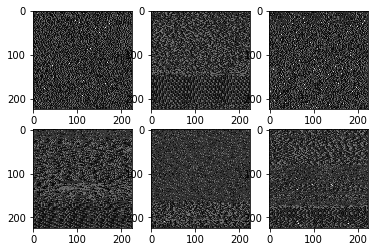

In [8]:
# Sample images from dataset
for i, img_path in enumerate(random.sample(img_list, 6)):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img, dtype=np.uint8)
    plt.subplot(2, 3, i+1)
    plt.imshow(img.squeeze())

In [5]:
# feature extraction
IMG_SHAPE = (224,224,3) # Input image shape
base_model = MobileNetV3Small(input_shape=IMG_SHAPE,
                         include_top=False,           
                         pooling ='avg',                                                       
                         weights='imagenet')

In [6]:
model = tf.keras.Sequential([base_model, tf.keras.layers.Dense(1024, activation='relu')])
                                                                                    # Applying keras sequential layer to 
                                                                                    # base model with relu activation to 
                                                                                    # extract only features from images 
                                                                                    # without making prediction
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 576)              939120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1024)              590848    
                                                                 
Total params: 1,529,968
Trainable params: 1,517,856
Non-trainable params: 12,112
_________________________________________________________________


In [8]:
data_labels = set(categories)
image_path = list(paths.list_images(base_path))
images = []                                                   # appending trainable features from MobileNetV1
labels = []                                                   # appending trainable lables from MobileNetV1
img_width = 224                                               # Image size
img_height = 224

In [9]:
for img in image_path:
    label = img.split(os.path.sep)[-2]
    image = cv2.imread(img)                                    # Reading images using CV2
    rezise_image = cv2.resize(image, (img_width, img_height))  # Resizing Images
    x = np.expand_dims(rezise_image, axis=0)                   # Converting x into 1-D array
    x = preprocess_input(x)
    features = model.predict(x)                                # Predicting features of X
    images.append(features)                                    # Appending features to train_features
    labels.append(label)

In [10]:
x = np.concatenate(images, axis=0)
y = np.array(labels)

In [11]:
x.shape

(10868, 1024)

In [12]:
# np.save('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV3__Small_X.npy', x)
# np.save('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_2/plots/MobileNetV3__Small_y.npy', y)

In [7]:
asm_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV3_Small_feat_asm_microsoft_1024.npy')
bytes_features = np.load('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Plots/MobileNetV3_Small_feat_bytes_microsoft_1024.npy')

In [8]:
X = []
for i in range(len(asm_features)):
    x = list(np.hstack((asm_features[i], bytes_features[i])))
    X.append(x)
X =  np.array(X)
X.shape

(10868, 2048)

In [9]:
import pandas as pd
import disarray as da
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, matthews_corrcoef, roc_curve, auc

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.21, random_state=42)

In [11]:
print("X_Train:", X_train.shape)
print("Y_Train:", y_train.shape)
print("X_Test:", X_test.shape)
print("Y_Test:", y_test.shape)

X_Train: (8585, 2048)
Y_Train: (8585,)
X_Test: (2283, 2048)
Y_Test: (2283,)


In [12]:
rf =  RandomForestClassifier(n_estimators= 100,n_jobs= 2)

In [13]:
%%time
rf.fit(X_train,y_train)

CPU times: user 21.5 s, sys: 91.3 ms, total: 21.6 s
Wall time: 10.9 s


RandomForestClassifier(n_jobs=2)

In [14]:
print("Testing Accuracy:", round((rf.score(X_test, y_test) * 100), 2))

Testing Accuracy: 94.17


In [15]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 133 ms, sys: 11.5 ms, total: 144 ms
Wall time: 109 ms


In [16]:
%%time
ls = precision_recall_fscore_support(y_test, y_pred, average='micro')
print(int(round(ls[0]*100, 0)), int(round(ls[1]*100, 0)), int(round(ls[2]*100, 0)))

94 94 94
CPU times: user 5.28 ms, sys: 52 µs, total: 5.33 ms
Wall time: 4.23 ms


In [17]:
accuracy_score(y_pred,y_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.94       217
         1.0       0.85      0.99      0.91        70
         2.0       1.00      1.00      1.00       623
         3.0       0.96      0.89      0.92       552
         4.0       0.89      0.95      0.92       229
         5.0       0.93      0.90      0.92       343
         6.0       0.14      1.00      0.25         1
         7.0       0.83      0.96      0.89       135
         8.0       0.96      0.95      0.95       113

    accuracy                           0.94      2283
   macro avg       0.83      0.95      0.86      2283
weighted avg       0.95      0.94      0.94      2283



In [18]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [24]:
%%time
# Perform cross-validation and grid search to find the best hyperparameters
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

CPU times: user 0 ns, sys: 153 µs, total: 153 µs
Wall time: 177 µs


In [25]:
%%time
grid_search.fit(X_train, y_train)

CPU times: user 20min 8s, sys: 2min 21s, total: 22min 29s
Wall time: 4h 27min 23s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=2),
             param_grid={'max_depth': [None, 10, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [26]:
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [27]:
%%time
print("Accuracy on testing set: {:.4f}".format(grid_search.score(X_test, y_test)))

Accuracy on testing set: 0.9400
CPU times: user 148 ms, sys: 11.5 ms, total: 159 ms
Wall time: 224 ms


In [29]:
y_pred = grid_search.predict(X_test)
print("Classification report:\n", classification_report(y_test, y_pred))

Classification report:
                 precision    recall  f1-score   support

         Gatak       0.41      0.10      0.16       228
  Kelihos_ver1       0.32      0.07      0.12        82
  Kelihos_ver3       0.85      0.93      0.89       636
      Lollipop       0.54      0.86      0.67       509
Obfuscator.ACY       0.83      0.72      0.77       246
        Ramnit       0.58      0.88      0.70       316
         Simda       0.00      0.00      0.00         9
        Tracur       0.30      0.02      0.04       152
         Vundo       0.50      0.01      0.02       105

      accuracy                           0.67      2283
     macro avg       0.48      0.40      0.37      2283
  weighted avg       0.62      0.67      0.60      2283



In [30]:
list_fams = sorted(label_dict.keys())

In [31]:
classification_metrices = metrics.classification_report(y_test, y_pred, output_dict=True, target_names= list_fams)
df = pd.DataFrame(classification_metrices).transpose()
df.to_csv('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV3__Small__RandomForest_st.csv')

Plotting the confusion matrix


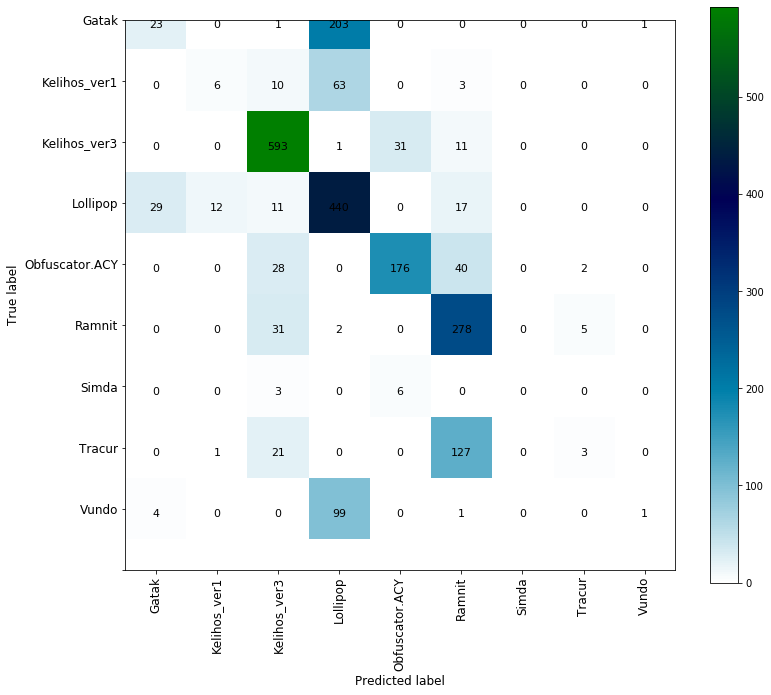

In [32]:
conf_matrix = confusion_matrix(y_test, y_pred)

print("Plotting the confusion matrix")
conf_mat = np.around(conf_matrix, decimals=2)  
figure = plt.gcf()
figure.set_size_inches(11, 10)
plt.imshow(conf_mat, interpolation='nearest', cmap='ocean_r')

for row in range(len(list_fams)):
    for col in range(len(list_fams)):
        plt.annotate(str(conf_mat[row][col]), xy=(col,row), ha='center', va='top', fontsize=11)
        
plt.xticks(range(len(list_fams)), list_fams, rotation=90, fontsize=12)
plt.yticks(range(len(list_fams)+1), list_fams, fontsize=12)

plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)

plt.tight_layout()
plt.colorbar()
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV3__Small__RandomForest_st.eps', bbox_inches='tight')
plt.savefig('/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV3__Small__RandomForest_st.png', bbox_inches='tight')

plt.show()

In [33]:
cm = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(cm)

In [34]:
pd.set_option('display.max_columns', None)  # force to display any number of columns.

In [35]:
#calculating true positives, false positives, true negatives and false negatives from confusion matrix
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

In [36]:
FP, FN, TP, TN

(array([ 33,  13, 105, 368,  37, 199,   0,   7,   1]),
 array([205,  76,  43,  69,  70,  38,   9, 149, 104]),
 array([ 23,   6, 593, 440, 176, 278,   0,   3,   1]),
 array([2022, 2188, 1542, 1406, 2000, 1768, 2274, 2124, 2177]))

In [37]:
#calculating false_omission_rate
NPV = TN/(TN+FN)
FOR = 1-NPV
FOR

array([0.09205209, 0.0335689 , 0.02712934, 0.04677966, 0.03381643,
       0.02104097, 0.00394218, 0.06555213, 0.04559404])

In [38]:
data = df.da.export_metrics(metrics_to_include=['true_positive_rate', 'true_negative_rate', 'false_positive_rate', 
                                              'false_negative_rate', 'false_discovery_rate'])

In [39]:
for num, fam in zip(range(25), list_fams):
    data.rename(columns={data.columns[num]:fam}, inplace=True)

data1 = data.drop(columns=['micro-average'])
data1 = data1.T
# data.drop(df.tail(1).index,inplace=True)

data1['false_omission_rate'] = list(FOR)

data1

,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,false_discovery_rate,false_omission_rate
Gatak,0.100877,0.983942,0.016058,0.899123,0.589286,0.092052
Kelihos_ver1,0.073171,0.994094,0.005906,0.926829,0.684211,0.033569
Kelihos_ver3,0.932390,0.936248,0.063752,0.067610,0.150430,0.027129
Lollipop,0.864440,0.792559,0.207441,0.135560,0.455446,0.046780
Obfuscator.ACY,0.715447,0.981836,0.018164,0.284553,0.173709,0.033816
Ramnit,0.879747,0.898831,0.101169,0.120253,0.417191,0.021041
Simda,0.000000,1.000000,0.000000,1.000000,NaN,0.003942
Tracur,0.019737,0.996715,0.003285,0.980263,0.700000,0.065552
Vundo,0.009524,0.999541,0.000459,0.990476,0.500000,0.045594


In [40]:
for i in data1:
    print('Average of', i, '-->', round((np.average(data1[i])*100), 4))

Average of true_positive_rate --> 39.9481
Average of true_negative_rate --> 95.3752
Average of false_positive_rate --> 4.6248
Average of false_negative_rate --> 60.0519
Average of false_discovery_rate --> nan
Average of false_omission_rate --> 4.1053


In [41]:
#MCC value
print('MCC Score:', round(matthews_corrcoef(y_test, y_pred), 2))

MCC Score: 0.59


In [42]:
print("micro_precision :", metrics.precision_score(y_test, y_pred, average='micro'))
print("micro_recall :", metrics.recall_score(y_test, y_pred, average='micro'))
print("micro_f1_score :", metrics.f1_score(y_test, y_pred, average='micro'))

micro_precision : 0.6657906263688129
micro_recall : 0.6657906263688129
micro_f1_score : 0.6657906263688129


In [43]:
print("macro_precision :", metrics.precision_score(y_test, y_pred, average='macro'))
print("macro_recall :", metrics.recall_score(y_test, y_pred, average='macro'))
print("macro_f1_score :", metrics.f1_score(y_test, y_pred, average='macro'))

macro_precision : 0.4810809688386635
macro_recall : 0.39948139799175647
macro_f1_score : 0.37353028244950437


In [44]:
enc = OneHotEncoder()
enc.fit(y_train.reshape(-1, 1))  
y_test = enc.transform(y_test.reshape(-1, 1))
y_pred = enc.transform(y_pred.reshape(-1, 1))

In [45]:
y_test = y_test.toarray()
y_pred = y_pred.toarray()

In [46]:
n_classes = 9

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

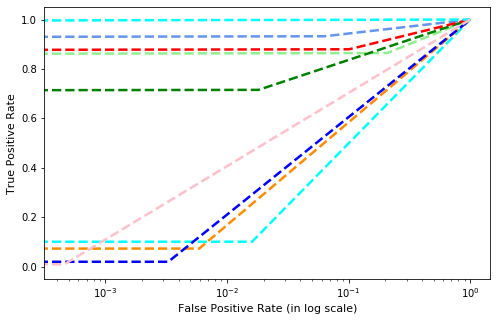

In [47]:
# Compute macro-average ROC curve and ROC area

n_classes = 9
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2.5   # line width
plt.figure(figsize=(8,5))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'lightgreen', 'green', 'red', 'cyan', 'blue', 
                 'pink', 'purple', 'brown', 'coral', 'chocolate', 'indigo', 'navy'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, linestyle='dashed', lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.xscale("log")
plt.xlabel('False Positive Rate (in log scale)', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV3__Small__microsoft_roc_RandomForest_st.eps", bbox_inches='tight')
plt.savefig("/home/sanjeev/DL_Exp_Malware/DL_Prasad_Exp/Microsoft_PoC/Experiment_3/plots/MobileNetV3__Small__microsoft_roc_RandomForest_st.png", bbox_inches='tight')

plt.show()